In [2]:
import anndata
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

from mcDETECT.utils import *
from mcDETECT.model import *
from mcDETECT.downstream import *

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0

In [38]:
# File paths
dataset = "MERSCOPE_WT_1"
data_path = f"../data/{dataset}/"
output_path = f"../output/{dataset}/"
comparison_path = f"../output/MERSCOPE_WT_AD_comparison/"

if dataset == "MERSCOPE_WT_1":
    flip = True
    cutoff = 6250
    theta = 10 * np.pi / 180
    coordinate_for_rotation = ["sphere_y", "sphere_x"]
    coordinate_for_flip = "global_y"
    granule_markers_plot = ["Camk2a", "Cplx2", "Slc17a7", "Syp", "Ddn", "Map1a", "Syn1", "Shank1", "Cyfip2", "Vamp2"]
    neuron_markers_plot = ["Trpc4", "Gjc3", "Plekhb1", "Ntrk2", "Ntsr2", "Fn1", "Gnai2", "Shc3", "Reep3", "Chd9", "Acsbg1"]
else:
    flip = True
    cutoff = 6250
    theta = 10 * np.pi / 180
    coordinate_for_rotation = ["sphere_y", "sphere_x"]
    coordinate_for_flip = "global_y"
    granule_markers_plot = ["Camk2a", "Cplx2", "Slc17a7", "Syp", "Ddn", "Map1a", "Syn1", "Shank1", "Cyfip2", "Vamp2"]
    neuron_markers_plot = ["Trpc4", "Gjc3", "Plekhb1", "Ntrk2", "Ntsr2", "Fn1", "Gnai2", "Shc3", "Reep3", "Chd9", "Acsbg1"]

In [4]:
# Colors
color_dct = ["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
color_cts = clr.LinearSegmentedColormap.from_list("magma", ["#000003", "#3B0F6F", "#8C2980", "#F66E5B", "#FD9F6C", "#FBFCBF"], N=256)

In [17]:
# -------------------- Read data -------------------- #

# Cells
adata = sc.read_h5ad(data_path + "processed_data/adata.h5ad")

# Neurons
adata_neuron = adata[adata.obs["cell_type"].isin(["Glutamatergic", "GABAergic"])].copy()

# Transcripts
transcripts = pd.read_parquet(data_path + "processed_data/transcripts.parquet")

# Genes
genes = pd.read_csv(data_path + "processed_data/genes.csv")
genes = list(genes.iloc[:, 0])

# Negative control markers
nc_genes = pd.read_csv(data_path + "processed_data/negative_controls.csv")
nc_genes = list(nc_genes["Gene"])

# Spots
spots = sc.read_h5ad(data_path + "processed_data/spots.h5ad")

In [19]:
# Markers
syn_genes = ["Camk2a", "Cplx2", "Slc17a7", "Ddn", "Syp", "Map1a", "Shank1", "Syn1", "Gria1", "Gria2", "Cyfip2", "Vamp2", "Bsn", "Slc32a1", "Nfasc", "Syt1", "Tubb3", "Nav1", "Shank3", "Mapt"]
len(syn_genes)

20

In [20]:
# Initialize mcDETECT
mc = mcDETECT(type = "discrete", transcripts = transcripts, gnl_genes = syn_genes, nc_genes = nc_genes, eps = 1.5,
              minspl = 3, grid_len = 1, cutoff_prob = 0.95, alpha = 10, low_bound = 3, size_thr = 4.0,
              in_soma_thr = 0.1, l = 1, rho = 0.2, s = 1, nc_top = 20, nc_thr = 0.1)

In [8]:
# Read granules
granules = pd.read_parquet(output_path + "granules.parquet") # no "local" for HGCC output
granules.shape

(681337, 13)

In [ ]:
# Spot-level neuron and granule metadata
spot_neuron_all = spot_neuron(adata_neuron, spots)
spot_neuron_all.write_h5ad(comparison_path + f"{dataset}_neurons.h5ad")

spot_granule_all = spot_granule(granule = granules, spot = spots)
spot_granule_all.write_h5ad(comparison_path + f"{dataset}_granules.h5ad")

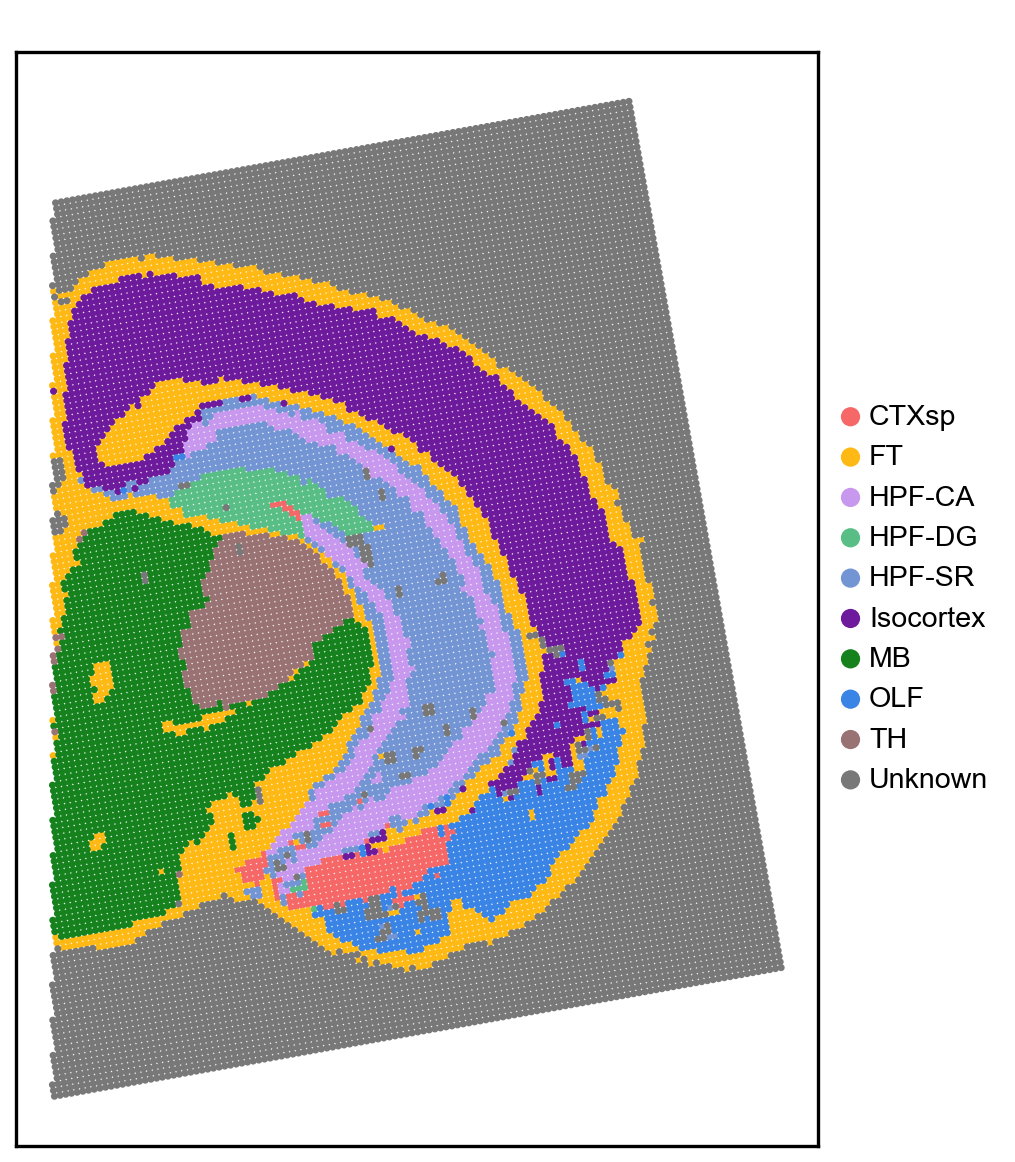

In [12]:
sc.set_figure_params(scanpy = True, figsize = (6, 9))
ax = sc.pl.scatter(spot_granule_all, alpha = 1, x = "global_y_new", y = "global_x_new", color = "brain_area", palette = color_dct, size = 40, title = " ", show = False)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")
frame_width = 1.5
for spine in ax.spines.values():
    spine.set_linewidth(frame_width)
plt.show()

In [13]:
granule_array = np.array(spot_granule_all.obs["gnl_count"])
neuron_array = np.array(spot_neuron_all.obs["neuron_count"])
area_array = np.array(spot_granule_all.obs["brain_area"])

granule_density, neuron_density = [], []

area_list = ["Isocortex", "OLF", "HPF-CA", "HPF-DG", "HPF-SR", "CTXsp", "TH", "MB", "FT"]
for j in area_list:
    granule_temp = granule_array[area_array == j]
    neuron_temp = neuron_array[area_array == j]
    granule_density.append(np.sum(granule_temp) / len(granule_temp))
    neuron_density.append(np.sum(neuron_temp) / len(neuron_temp))

density_comparison = pd.DataFrame({"area_list": area_list, "granule_density": granule_density, "neuron_density": neuron_density})
density_comparison.to_csv(comparison_path + "MERSCOPE_WT_1_granule_neuron_density.csv", index = 0)

In [14]:
# Plot granules
granule_adata = anndata.AnnData(X = np.zeros(granules.shape), obs = granules)
granule_adata.obs["brain_area"] = pd.Categorical(granule_adata.obs["brain_area"], categories = ["CTXsp", "FT", "HPF-CA", "HPF-DG", "HPF-SR", "Isocortex", "MB", "OLF", "TH"], ordered = True)

# cutoff = 6250
# granule_adata.obs["global_y_new"] = cutoff - granule_adata.obs["global_y_new"]

sc.set_figure_params(scanpy = True, figsize = (6, 9))
ax = sc.pl.scatter(granule_adata, alpha = 1, x = "global_y_new", y = "global_x_new", color = "brain_area", palette = color_dct, size = 1, title = " ", show = False)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")
for spine in ax.spines.values():
    spine.set_visible(False)
plt.savefig(output_path + "granules.png", dpi = 300, bbox_inches = "tight")
plt.close()

In [27]:
# Granule expression profile
granule_adata = sc.read_h5ad(output_path + "granule_adata_tsne.h5ad")
granule_adata

AnnData object with n_obs × n_vars = 681337 × 290
    obs: 'global_x', 'global_y', 'global_z', 'layer_z', 'sphere_r', 'size', 'comp', 'in_soma_ratio', 'gene', 'nc_ratio', 'granule_id'
    var: 'genes'
    uns: 'log1p', 'pca', 'tsne'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'
    layers: 'counts'

In [35]:
# Granule vs neuron expression (nuclei)
np.random.seed(42)
permuted_indices = np.random.permutation(granule_adata.n_obs)
granule_adata_permutated = granule_adata[permuted_indices].copy()

In [36]:
adata_all = anndata.concat([granule_adata_permutated, adata_neuron], axis = 0, merge = "same")
adata_all.var["genes"] = adata_all.var.index
adata_all.obs["type"] = ["Granules"] * granule_adata_permutated.shape[0] + ["Neurons"] * adata_neuron.shape[0]
adata_all.obs["type"] = pd.Categorical(adata_all.obs["type"], categories = ["Granules", "Neurons"], ordered = True)
adata_all

AnnData object with n_obs × n_vars = 729908 × 290
    obs: 'global_x', 'global_y', 'type'
    var: 'genes'

In [ ]:
gene_groups = {"Granule Markers": granule_markers_plot,
               "Neuron Markers": neuron_markers_plot}
target_genes = [gene for group in gene_groups.values() for gene in group]

var_group_positions = [(0, 10), (10, 20)]
var_group_labels = list(gene_groups.keys())

sc.set_figure_params(scanpy=True, fontsize=10)
fig = sc.pl.heatmap(adata_all, target_genes, groupby = "type", log = True, cmap = "Reds", standard_scale = "var", swap_axes = True, figsize = (10, 4), show = False)
plt.savefig(output_path + "granule_neuron_heatmap.jpeg", dpi = 300, bbox_inches = "tight")
plt.close()